<a href="https://colab.research.google.com/github/2SEHI/K-Digital_Lecture/blob/main/0728/RNN_kakao%EC%A3%BC%EC%8B%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN Layer(최상위 클래스 = RNN)
- RNN Layer를 만들고자 할 때 공통된 부분을 RNN에 만들어 놓고 상속을 받아서 쓰는 것

## SimpleRNN 
- RNN을 공부할 때 사용하며, 잘 쓰이지 않습니다.

## LSTM
- 오랫동안 기억
- 처음에 중요한 정보가 있는 경우 SimpleRNN은 진행하면 오래된 정보를 잊어버리기 때문에 성능이 저하될 수 밖에 없어서 이전 상태도 저장하기 위해서 사용합니다.


## kakao주식 분석
- 데이터
https://finance.yahoo.com/quote/035720.KS/history?p=035720.KS

- 타겟은 여러개가 될 수 있다. 다만 Bert를 사용할 때는 질문에 대한 응답이 한 개가 나오며 여러개의 출력층을 만들면 질의와 추천 두가지의 결과를 만들 수 있습니다.


In [ ]:
import numpy as np
import pandas as pd 
from pandas.io.parsers import read_csv

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM

items = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/kakao-inv.KS.csv')
items

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-07-28,18280.0,18400.0,18140.0,18320.0,18215.750000,1102880.0
1,2016-07-29,18300.0,18320.0,18180.0,18180.0,18076.544922,1180655.0
2,2016-08-01,18300.0,18320.0,18120.0,18200.0,18096.427734,1174915.0
3,2016-08-02,18200.0,18260.0,18160.0,18200.0,18096.427734,614470.0
4,2016-08-03,18140.0,18840.0,18120.0,18780.0,18673.130859,2082885.0
...,...,...,...,...,...,...,...
1223,2021-07-22,144500.0,148000.0,142500.0,147500.0,147500.000000,5759268.0
1224,2021-07-23,148500.0,153500.0,147500.0,149500.0,149500.000000,5249906.0
1225,2021-07-26,151500.0,153000.0,146500.0,147500.0,147500.000000,4071898.0
1226,2021-07-27,147500.0,149000.0,145500.0,148000.0,148000.000000,3357695.0


In [ ]:
items.isnull().sum()
items.dropna(how='any', inplace=True)

## 레이블 생성 - high와 low의 평균


In [ ]:
high_price = items['High'].values
low_price = items['Low'].values
mid_price = (high_price + low_price) / 2

## 분할
- RNN을 이용해서 시계열 예측을 하기 위해서 데이터를 적당한 단위로 분할해야 합니다.
- 50개 단위로 분할을 한다면, 1부터 50까지로 51을 예상, 2부터 51까지로 52를 예상, 3부터 52까지로 353를 예상... 이런식으로 예측한 후 실제 데이터와의 loss를 계산합니다.

 

In [ ]:
day_divded = 50
day_length = day_divded +1
day_result = []
for i in range(len(mid_price) - day_length):
    day_result.append(mid_price[i:i + day_length])

print(day_result[0], day_result[1])

[18270. 18250. 18220. 18210. 18480. 18610. 18560. 18390. 18460. 18600.
 18550. 18070. 17840. 17730. 17510. 17130. 16740. 16410. 16380. 16400.
 16200. 16020. 16020. 16100. 16300. 16290. 16310. 16300. 16030. 16190.
 16180. 15970. 16050. 16050. 16410. 16370. 16710. 16780. 16560. 16600.
 16600. 16490. 16590. 16390. 16730. 17040. 16870. 16620. 16440. 16050.
 15980.] [18250. 18220. 18210. 18480. 18610. 18560. 18390. 18460. 18600. 18550.
 18070. 17840. 17730. 17510. 17130. 16740. 16410. 16380. 16400. 16200.
 16020. 16020. 16100. 16300. 16290. 16310. 16300. 16030. 16190. 16180.
 15970. 16050. 16050. 16410. 16370. 16710. 16780. 16560. 16600. 16600.
 16490. 16590. 16390. 16730. 17040. 16870. 16620. 16440. 16050. 15980.
 15880.]


## 시계열 데이터의 데이터 정규화
- 일반적인 정규화 방법에는 MinMaxScalear, StandardScaler, Log 변환 등의 방법이 있습니다
- 시계열 데이터에서는 이러한 방법을 사용하지 않는 경우가 있습니다. 왜냐하면 MinMaxScalear, StandardScaler의 경우 기준점이 있는데 시계열 예측은 현재 값을 가지고 미래 값을 예측하는 것입니다. 그런데 일반적인 정규화를 하게되면 현재 값이 음수가 될 수 있습니다. 주식의 경우 개장시의 주식은 전날 주식보다 떨어지지도 오르지도 않았기때문에 음수가 될 수 없습니다. 시계열 데이터에서는 첫번째 데이터가 기준점이 되서 0으로 놓고 나머지 데이터들이 첫번째 데이터를 기준으로 떨어졌나 높아졌나를 확인하는 첫번째 데이터와의 비율 형태로 정규화를 해야 합니다.

In [ ]:
norm_result = []
# 전체 데이터를 순회하면서 첫번째 데이터로 나눈 값에서 1을 빼서 저장
for section in day_result :
    norm_section = [((float(p) / float(section[0])) - 1)  for p in section]
    norm_result.append(norm_section)

day_result = np.array(norm_result)

print(day_result)

[[ 0.         -0.00109469 -0.00273673 ... -0.1001642  -0.12151067
  -0.12534209]
 [ 0.         -0.00164384 -0.00219178 ... -0.12054795 -0.12438356
  -0.12986301]
 [ 0.         -0.00054885  0.01427003 ... -0.12294182 -0.1284303
  -0.11909989]
 ...
 [ 0.          0.00228311  0.00456621 ...  0.36986301  0.32648402
   0.37442922]
 [ 0.          0.0022779   0.02733485 ...  0.32346241  0.37129841
   0.36446469]
 [ 0.          0.025       0.03409091 ...  0.36818182  0.36136364
   0.33863636]]


## 훈련데이터와 테스트데이터의 분리
- 

In [ ]:
train_data_rate = 0.9
boundary = round(day_result.shape[0] * train_data_rate)

# 177, 51
train_data = day_result[:boundary, :]
# 20, 51
test_data = day_result[boundary:, :]

# (177, 50, 1)
x_train = train_data[:, :-1]
# 3차원으로 변경 (177, 50, 1)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1], 1))
# (177,)
y_train = train_data[:, -1]

# (20, 50)
x_test = test_data[:, :-1]
# 3차원으로 변경  (20, 50, 1)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
# (20,)
y_test = test_data[:, -1]

print(x_train.shape)
print(x_test.shape)

print(y_train.shape)
print(y_test.shape)


(1055, 50, 1)
(117, 50, 1)
(1055,)
(117,)


## 모델 생성
- relu :  이 함수는 쉽게 말해 0보다 작은 값이 나온 경우 0을 반환하고, 0보다 큰 값이 나온 경우 그 값을 그대로 반환하는 함수다. 0보다 큰 값일 경우 1을 반환하는 sigmoid와 다르다. 따라서 내부 hidden layer에는 ReLU를 적용하고, 마지막 output layer에서만 sigmoid 함수를 적용하면 이전에 비해 정확도가 훨씬 올라가게 된다.
- 활성화 함수(Activation Function)에는 Sigmoid, Leaky RelU, tanh, maxout, ReLU, ELU 가 있다.

In [ ]:
model = Sequential()

# 입력층 추가
# 입력 데이터의 shape를 설정해야 하고 다음에 RNN층이 온다면
# return_sequence를 True로 설정해야 합니다.
model.add(LSTM(50, return_sequences=True, input_shape=(50, 1)))
# 마지막 RNN층은 다음 층으로 출력을 전달할 필요가 없습니다.
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1, activation='relu'))
model.compile(loss='mse', optimizer='sgd')
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 50, 50)            10400     
_________________________________________________________________
lstm_21 (LSTM)               (None, 64)                29440     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


## 훈련


In [ ]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), 
                    batch_size=10, 
                    epochs=15)

Epoch 1/15
106/106 [==============================] - 9s 55ms/step - loss: 0.0464 - val_loss: 0.0836
Epoch 2/15
106/106 [==============================] - 5s 47ms/step - loss: 0.0463 - val_loss: 0.0836
Epoch 3/15
106/106 [==============================] - 5s 46ms/step - loss: 0.0463 - val_loss: 0.0836
Epoch 4/15
106/106 [==============================] - 5s 45ms/step - loss: 0.0463 - val_loss: 0.0836
Epoch 5/15
106/106 [==============================] - 5s 47ms/step - loss: 0.0463 - val_loss: 0.0836
Epoch 6/15
106/106 [==============================] - 5s 45ms/step - loss: 0.0463 - val_loss: 0.0836
Epoch 7/15
106/106 [==============================] - 5s 45ms/step - loss: 0.0463 - val_loss: 0.0836
Epoch 8/15
106/106 [==============================] - 5s 45ms/step - loss: 0.0463 - val_loss: 0.0836
Epoch 9/15
106/106 [==============================] - 5s 46ms/step - loss: 0.0463 - val_loss: 0.0836
Epoch 10/15
106/106 [==============================] - 5s 46ms/step - loss: 0.0463 - val_lo

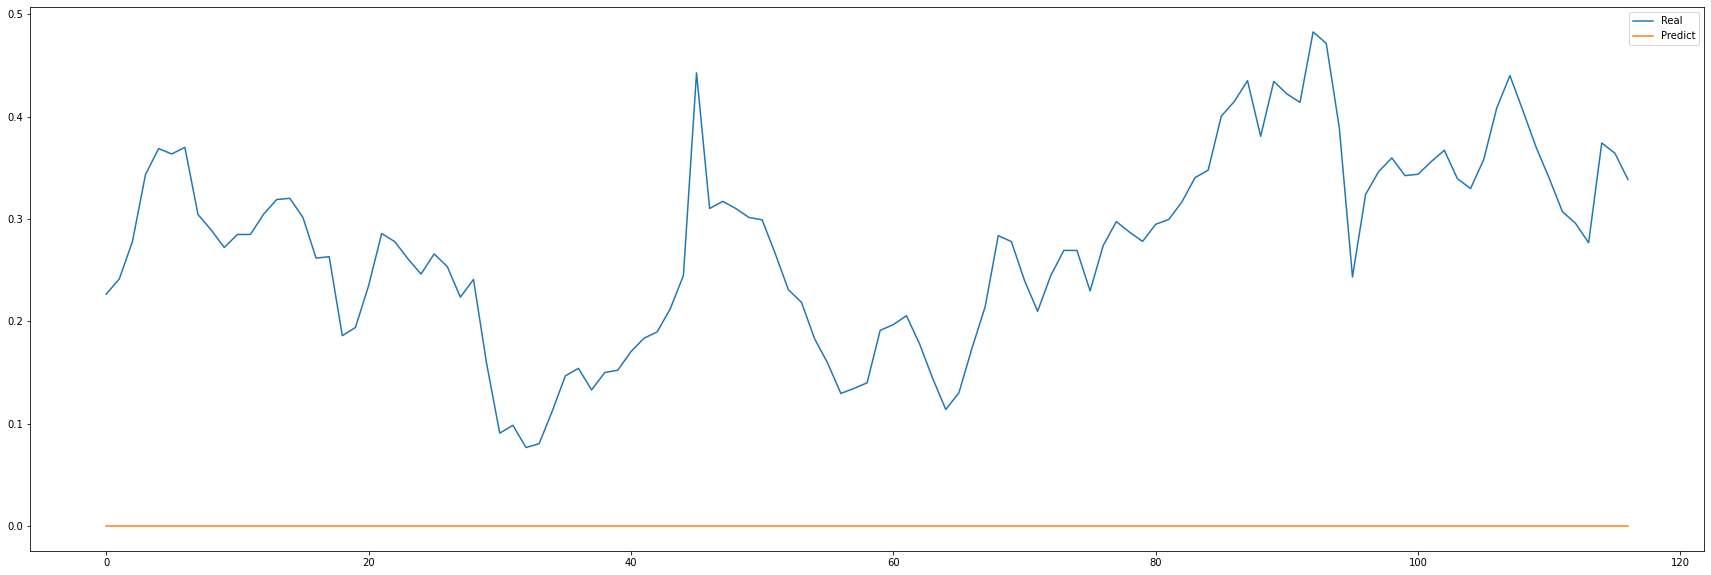

In [ ]:
pred=model.predict(x_test)

import matplotlib.pyplot as plt

plot_figure = plt.figure(figsize=(30,10))
plot_rst = plot_figure.add_subplot(111)
plot_rst.plot(y_test, label='Real')
plot_rst.plot(pred, label='Predict')
plot_rst.legend()
plt.show()